# Eksamensprojekt - Dataanalyse
# Gruppe: [Navne her]
# Dato: [Udfyld dato]

# %% [markdown]
# ## 1. Indledning (Sprint 1 - Problemformulering)
# Dette projekt har til formål at analysere frafald og gennemførelse på danske videregående uddannelser
# ved hjælp af Business Intelligence (BI) og maskinlæring.
# 
# **Problemformulering:** Hvordan kan man identificere uddannelser med høj risiko for frafald?
# 
# **Formål:** At udvikle en interaktiv BI-løsning, der kan hjælpe beslutningstagere med at forstå og
# handle på mønstre i frafaldsdata.
# 
# **Hypotese:** Uddannelser med høj frafaldsrate har identificerbare mønstre i gennemførelse og afbrud.
# 
# **Løsning:** Kombination af klassifikation og klyngeanalyse, visualiseringer og en interaktiv webapplikation.

# %% [markdown]
# ## 2. Databehandling og -forberedelse (Sprint 2 - Data Preparation)
# Baseret på de tidligere definerede idéer og antagelser:
# 1. Data indsamles og indlæses fra relevante kilder.
# 2. Data renses og integreres i passende datastrukturer. Der anvendes en ETL-proces (Extract, Transform, Load).
# 3. Deskriptiv statistik anvendes til at udforske og analysere datasættet.
#    Visualiseringer og diagrammer skabes for bedre forståelse og planlægning.
# 4. Data engineering sikrer, at dataene er:
#     a. meningsfulde – beskriver relevante og korrekt målte observationer
#     b. tilstrækkelige – dækker flere år og uddannelser
#     c. strukturerede – i et analysérbart format
#     d. rensede – håndtering af manglende værdier og outliers
#     e. skalerede – ensartede fordelinger til modellering
#     f. feature-engineerede – udvalgt de mest informative attributter

# %%
# 3. Import af biblioteker og moduler

In [196]:
import sys
sys.path.append("/mnt/data")

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#from visualization import plot_completion_vs_dropout
#from central_tendency import summarize_central_tendency



In [198]:
# 4. Indlæsning og forberedelse af data
file_path = "Streamlit/Data/Uddannelse_combined.xlsx"
df = pd.read_excel(file_path)

In [199]:
fuldfort = df[df['Type'] == 'Fuldført']
afbrudt = df[df['Type'] == 'Afbrudt']

In [200]:
# Aggregering af data per uddannelse
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
agg_fuldfort = fuldfort.groupby(['FagLinjer'])[years].sum().reset_index()
agg_afbrudt = afbrudt.groupby(['FagLinjer'])[years].sum().reset_index()

In [201]:
# Merge data
merged = pd.merge(agg_fuldfort, agg_afbrudt, on='FagLinjer', suffixes=('_fuldfort', '_afbrudt'))

In [202]:
# Beregn samlet statistik og frafaldsrate
merged['Total_fuldfort'] = merged[[f"{y}_fuldfort" for y in years]].sum(axis=1)
merged['Total_afbrudt'] = merged[[f"{y}_afbrudt" for y in years]].sum(axis=1)
merged['Frafaldsrate'] = merged['Total_afbrudt'] / (merged['Total_fuldfort'] + merged['Total_afbrudt'])

In [203]:

# Sorter for konklusion
merged_sorted = merged.sort_values(by='Frafaldsrate', ascending=False)
hojest_frafald = merged_sorted[['FagLinjer', 'Frafaldsrate']].head(5)
print("Top 5 faglinjer med højest frafaldsrate:")
print(hojest_frafald)

Top 5 faglinjer med højest frafaldsrate:
               FagLinjer  Frafaldsrate
4           Natur, bach.      0.410680
1       Humaniora, bach.      0.379378
15   Teknik, prof. bach.      0.373079
13         Teknik, bach.      0.341371
9   Samfund, prof. bach.      0.320396


In [204]:
# 5. Supervised Learning - Regression (forudsigelse af frafaldsrate)
features = merged[['Total_fuldfort', 'Total_afbrudt']]
target = merged['Frafaldsrate']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

In [205]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R2 Score:", r2)


Mean Squared Error: 0.0077474372882825465
R2 Score: 0.5370723204356667


In [206]:
# Forudsigelse af fremtidige frafaldsrate (eksempel)
merged['Pred_frafaldsrate'] = reg_model.predict(merged[['Total_fuldfort', 'Total_afbrudt']])

In [207]:
# 6. Unsupervised Learning - Klyngeanalyse (Sprint 3)
X_cluster = merged[['Frafaldsrate']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

silhouette_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append((k, score))

In [208]:
# Bedste antal klynger
best_k = max(silhouette_scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)
merged['Cluster'] = kmeans.labels_

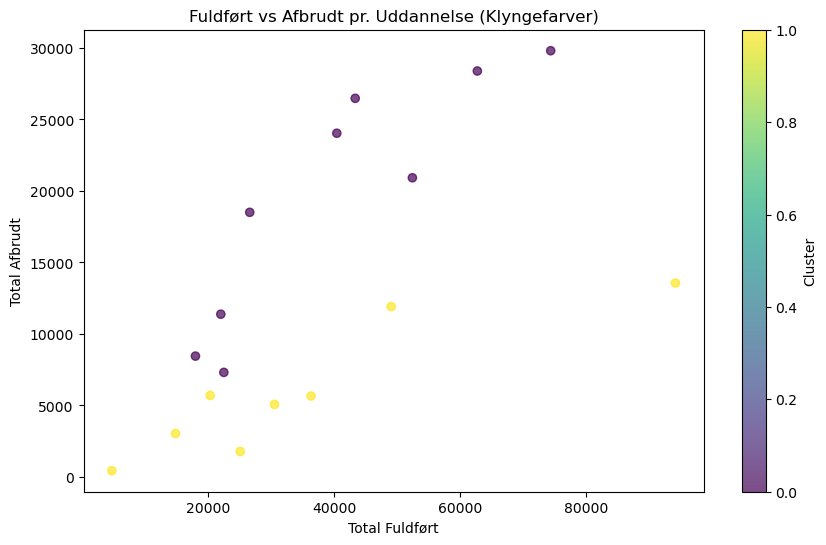

In [209]:
# 7. Visualisering (Sprint 4)
plot_completion_vs_dropout(merged)

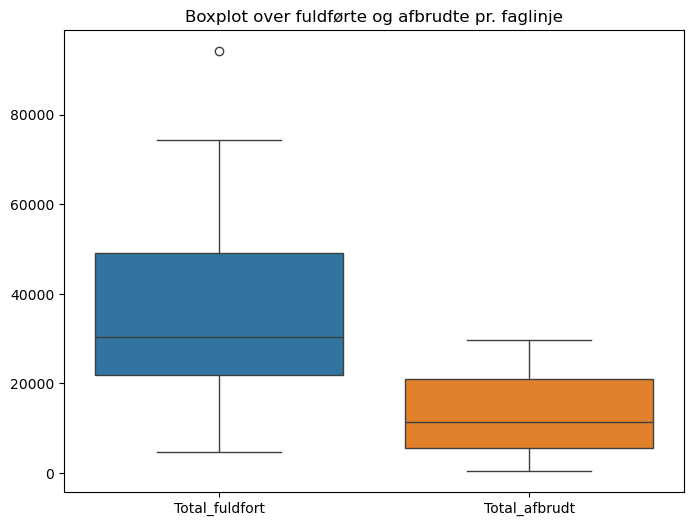

In [210]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged[['Total_fuldfort', 'Total_afbrudt']])
plt.title('Boxplot over fuldførte og afbrudte pr. faglinje')
plt.show()

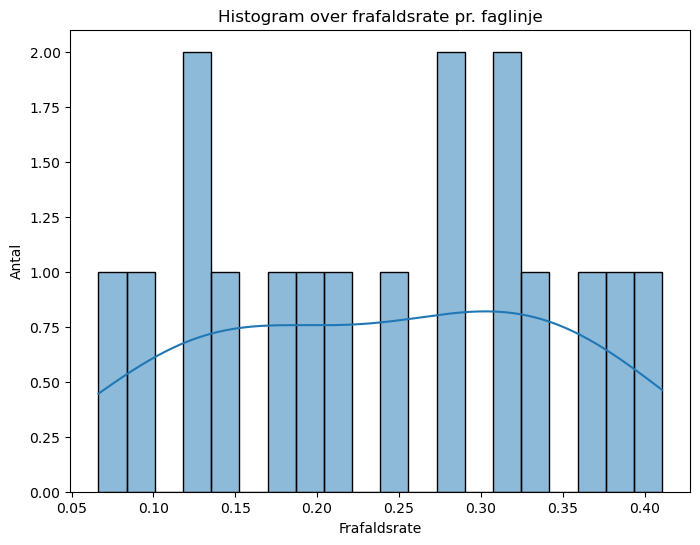

In [211]:
# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(merged['Frafaldsrate'], bins=20, kde=True)
plt.title('Histogram over frafaldsrate pr. faglinje')
plt.xlabel('Frafaldsrate')
plt.ylabel('Antal')
plt.show()

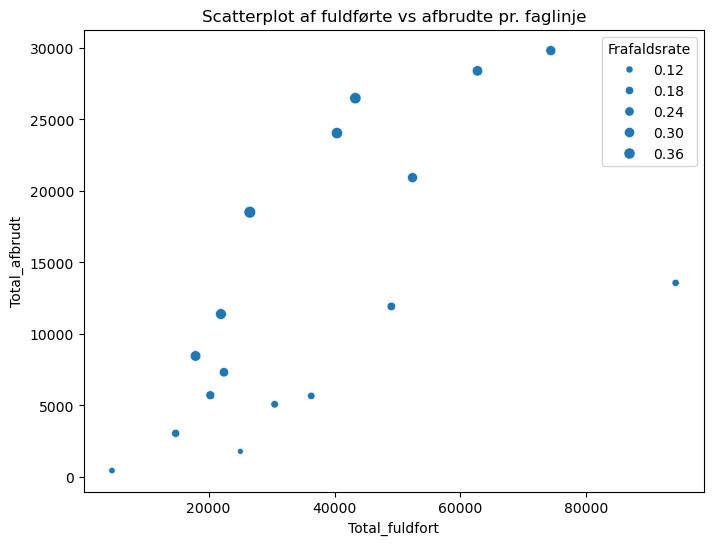

In [212]:
# Scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Total_fuldfort', y='Total_afbrudt', size='Frafaldsrate', data=merged)
plt.title('Scatterplot af fuldførte vs afbrudte pr. faglinje')
plt.show()

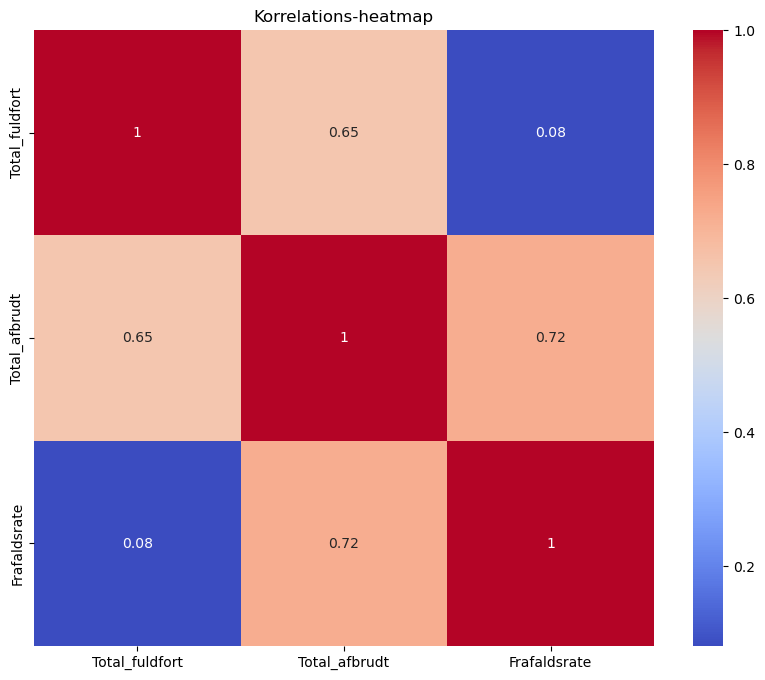

In [213]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged[['Total_fuldfort', 'Total_afbrudt', 'Frafaldsrate']].corr(), annot=True, cmap='coolwarm')
plt.title('Korrelations-heatmap')
plt.show()

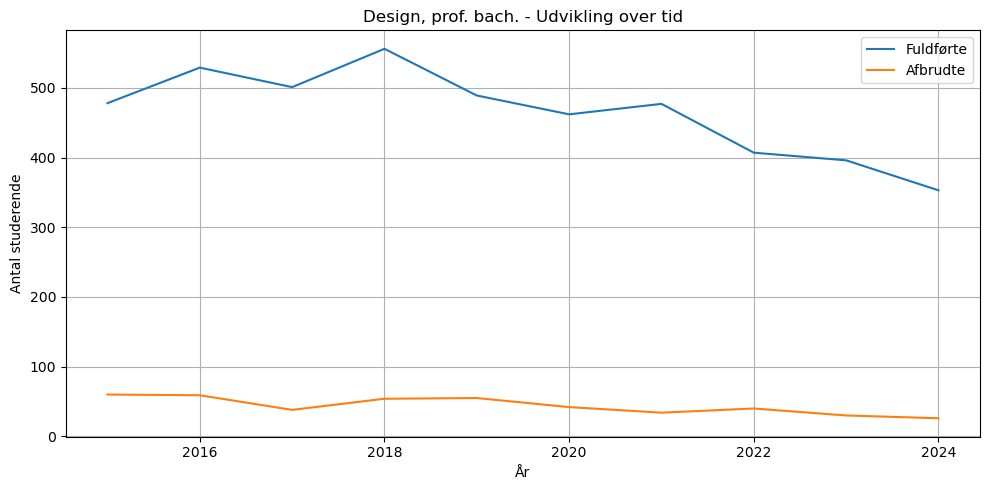

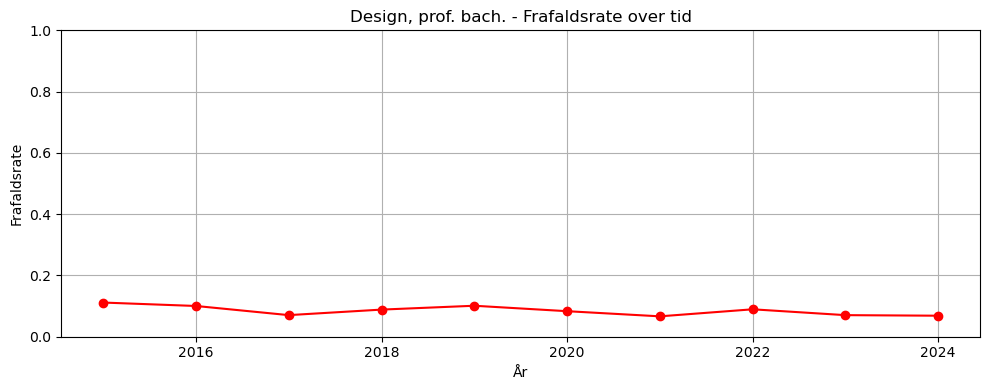

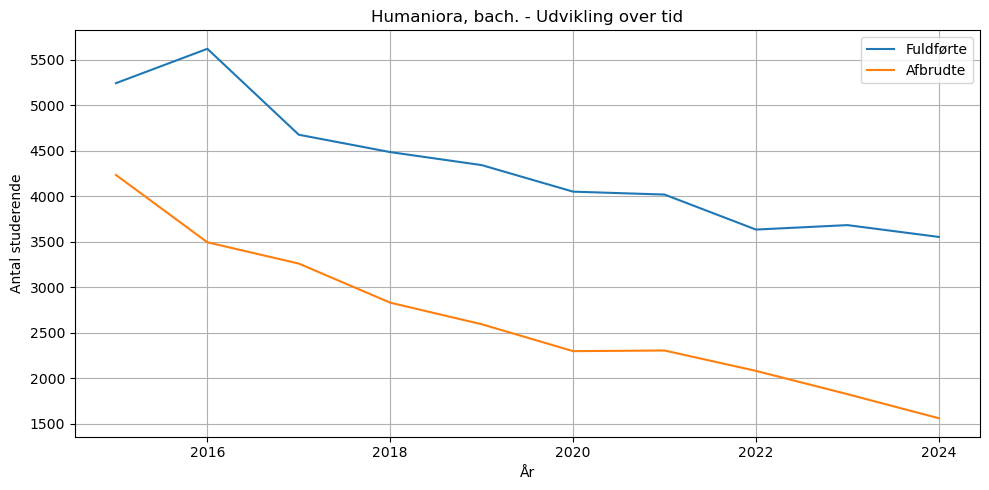

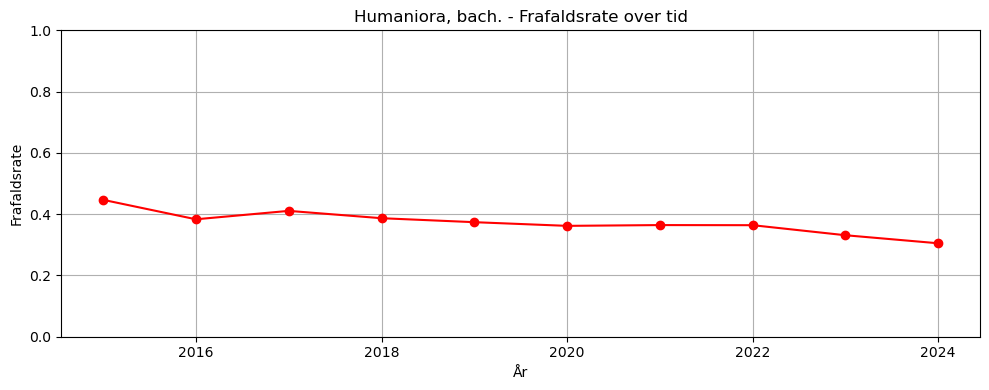

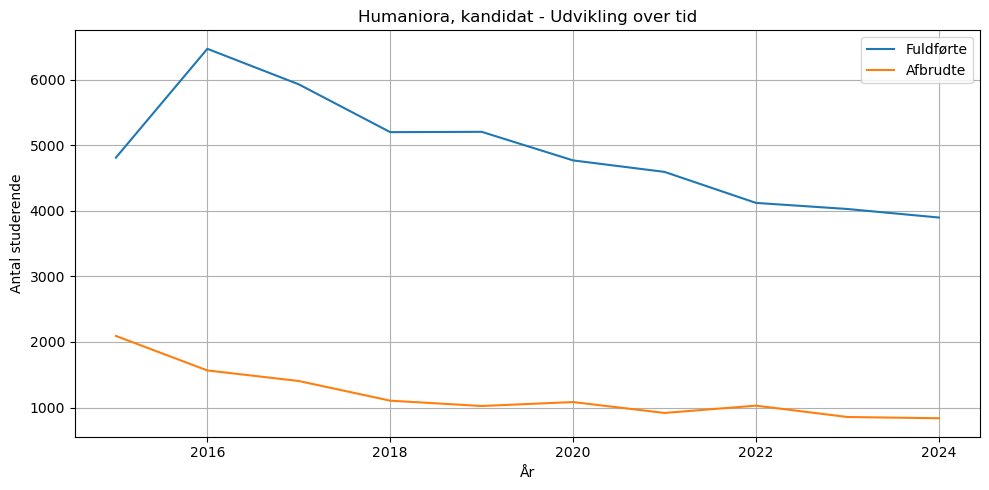

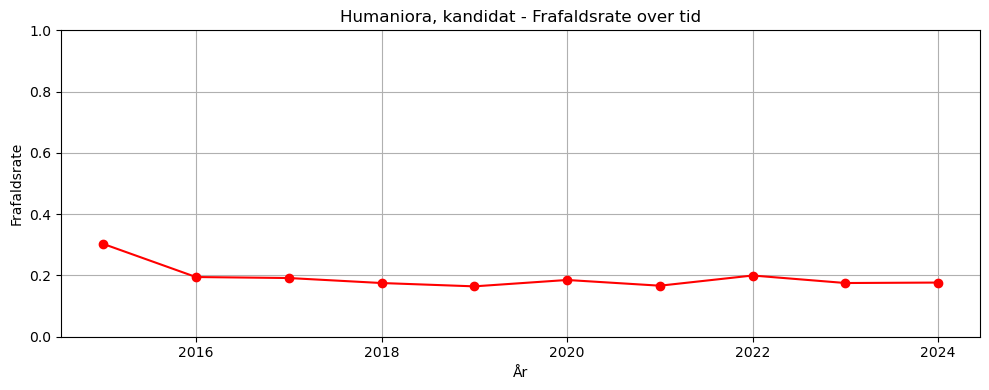

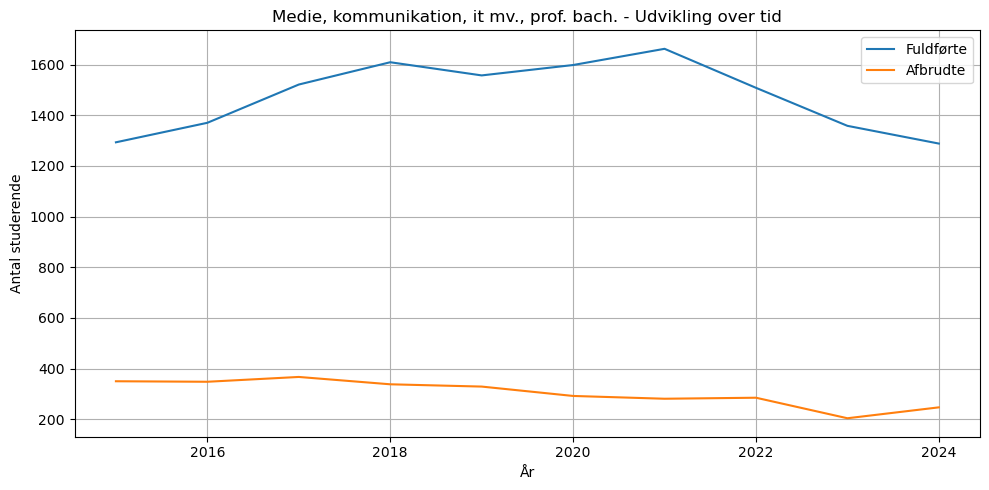

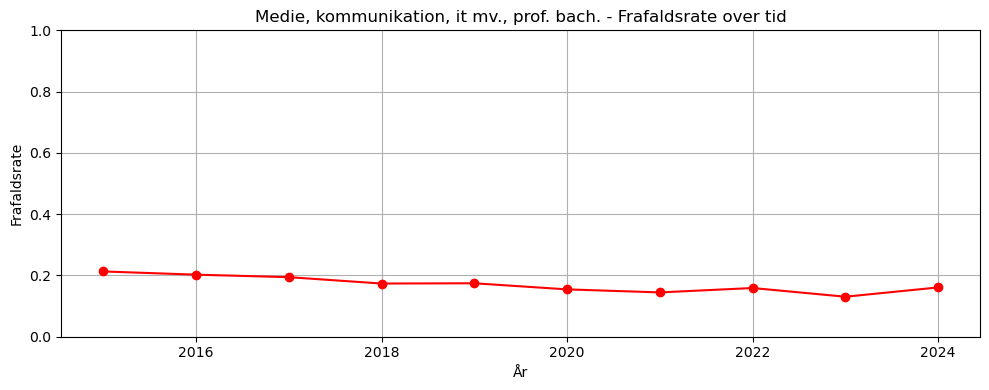

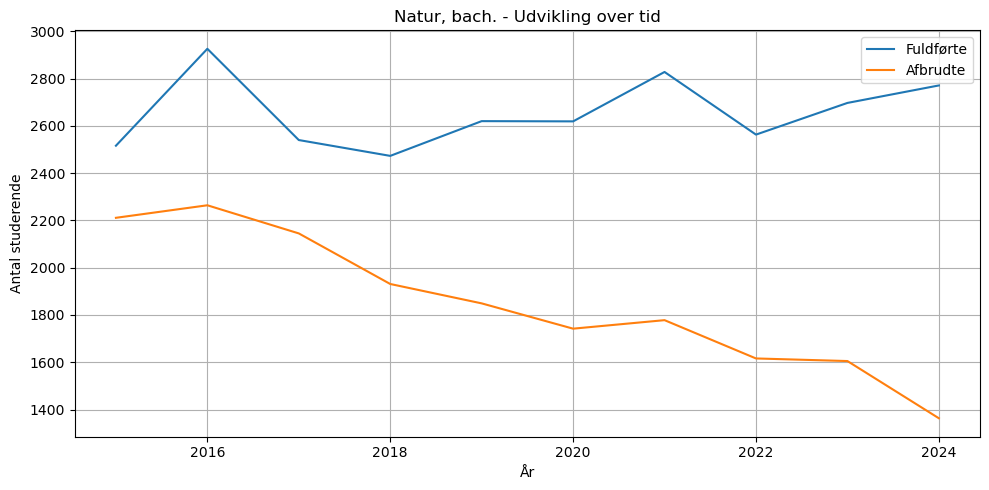

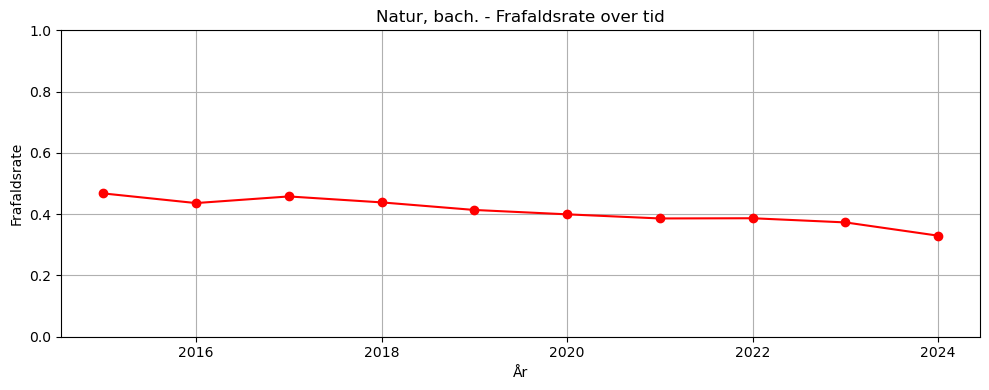

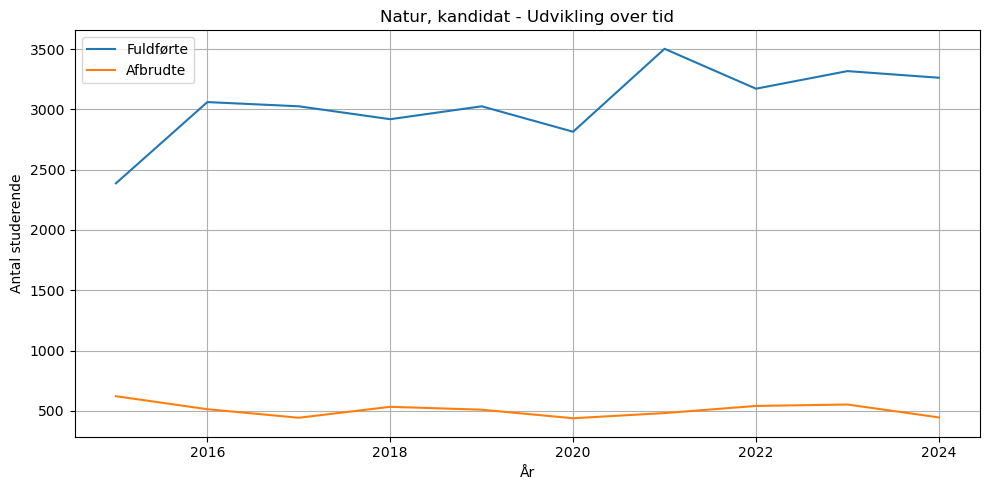

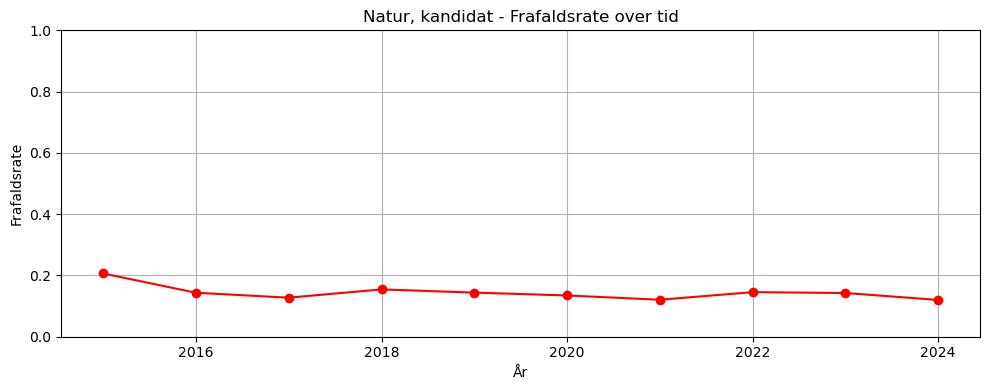

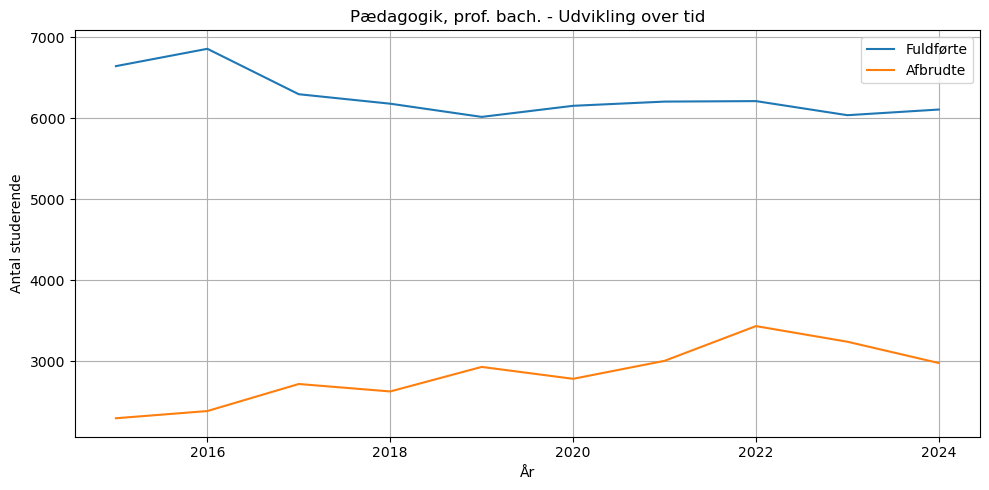

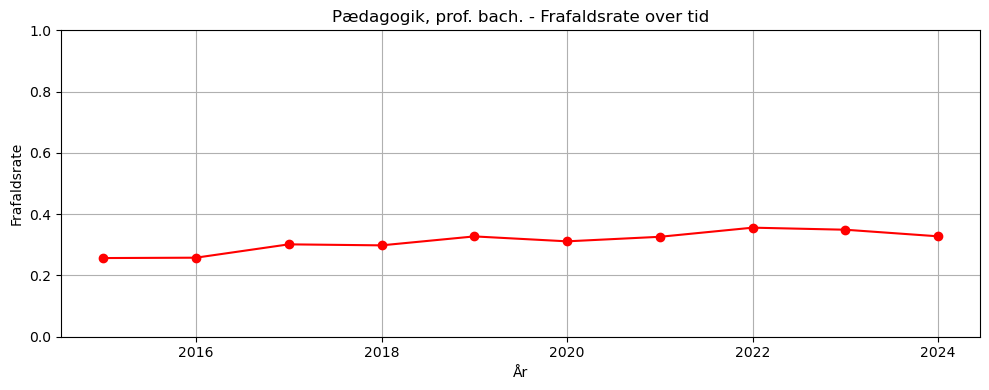

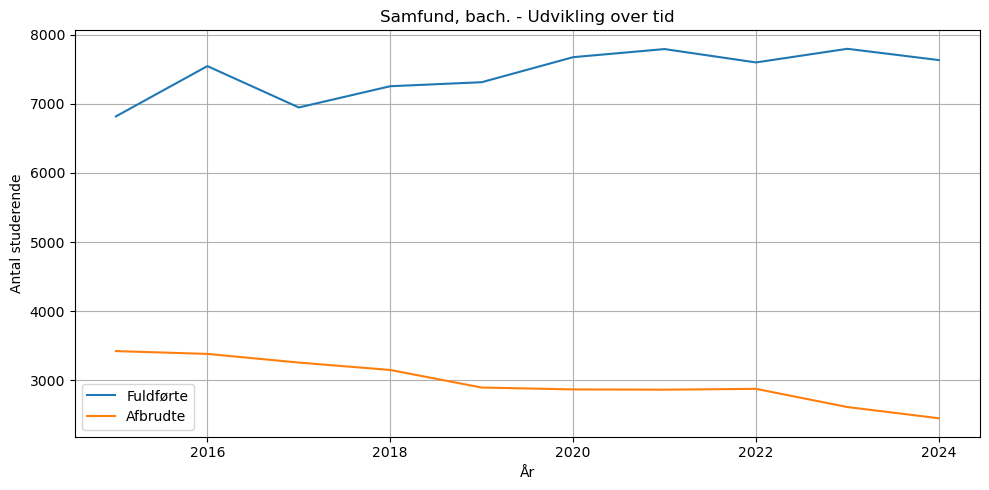

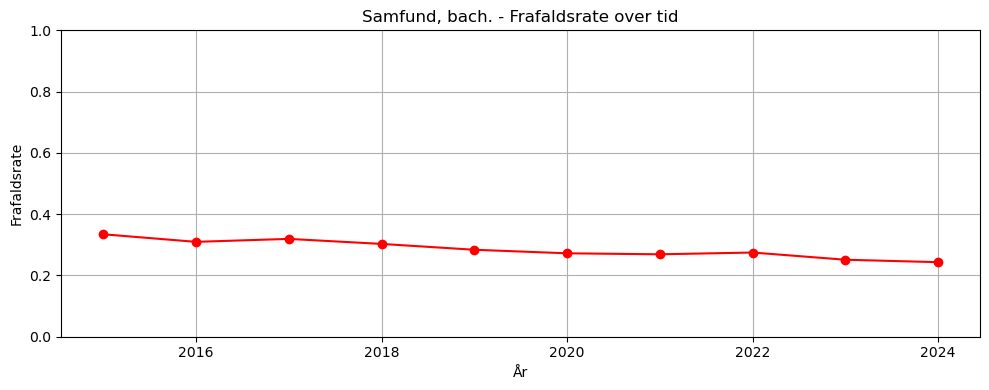

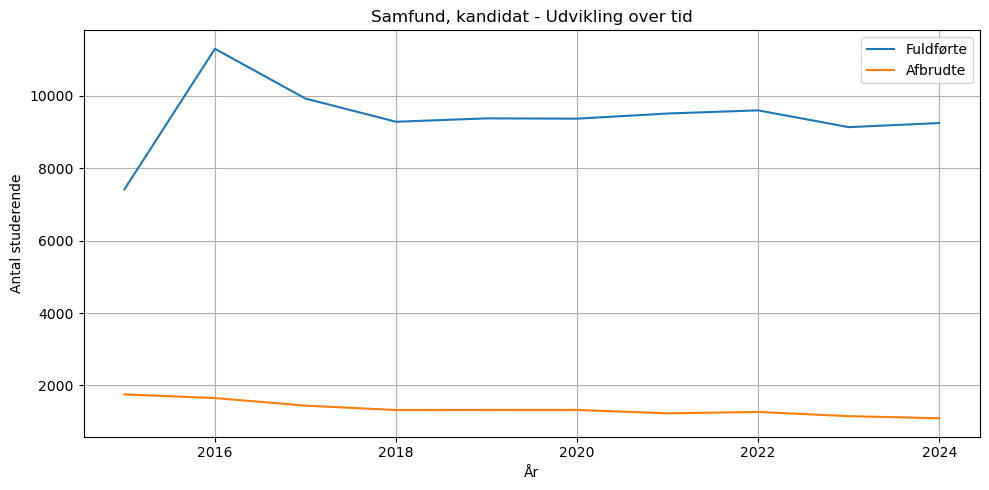

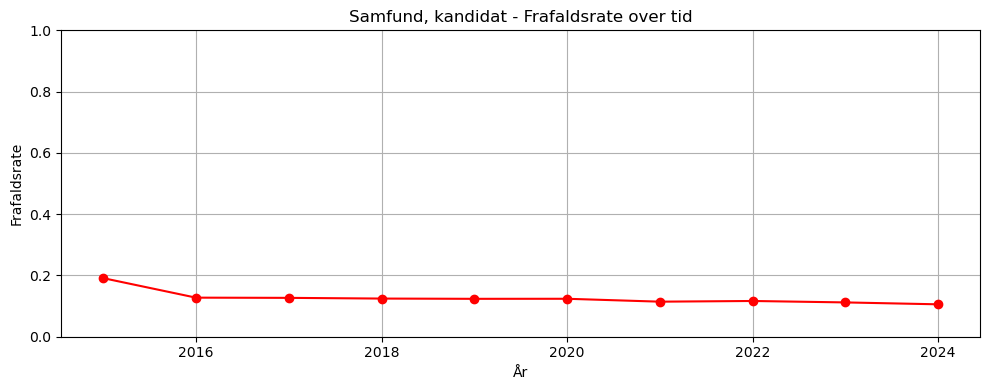

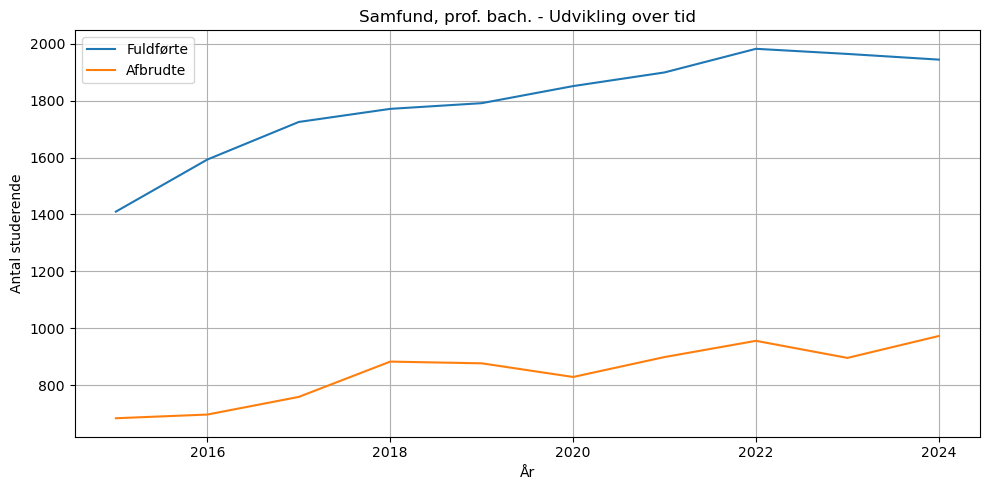

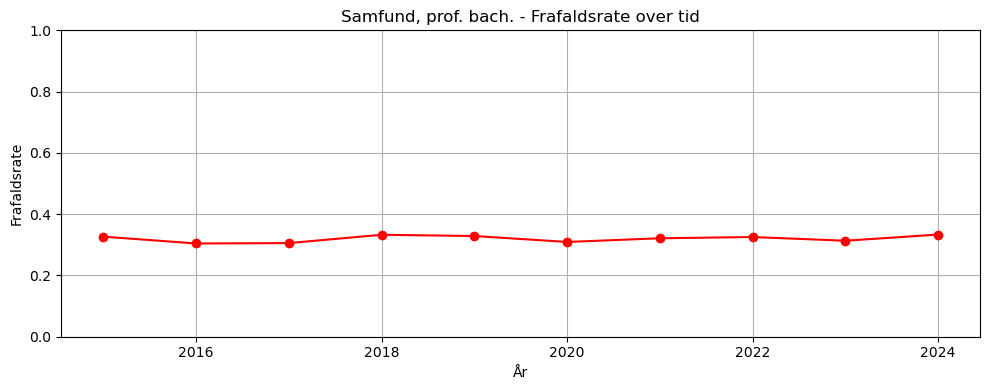

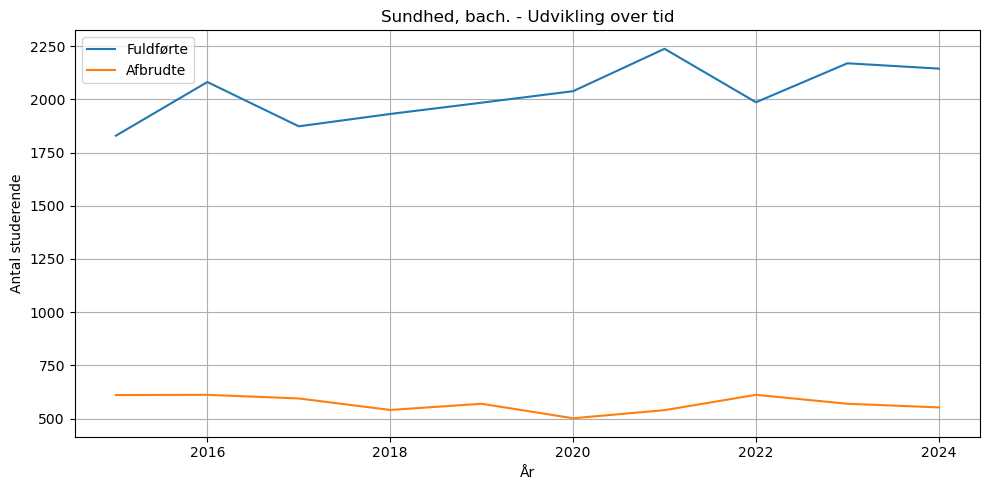

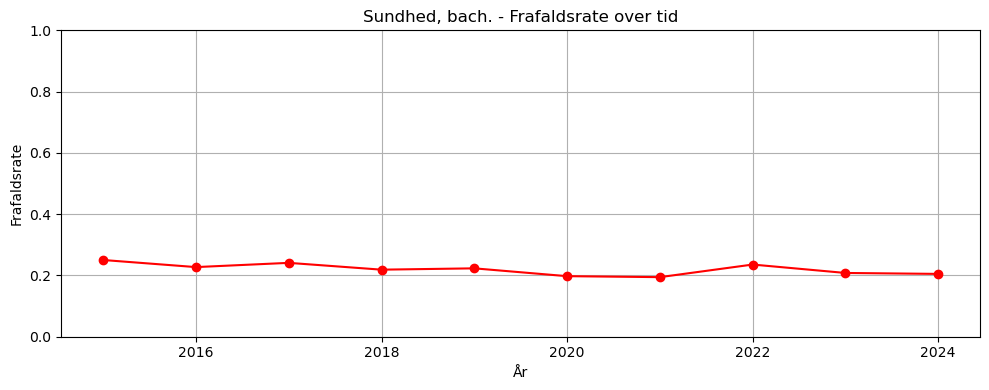

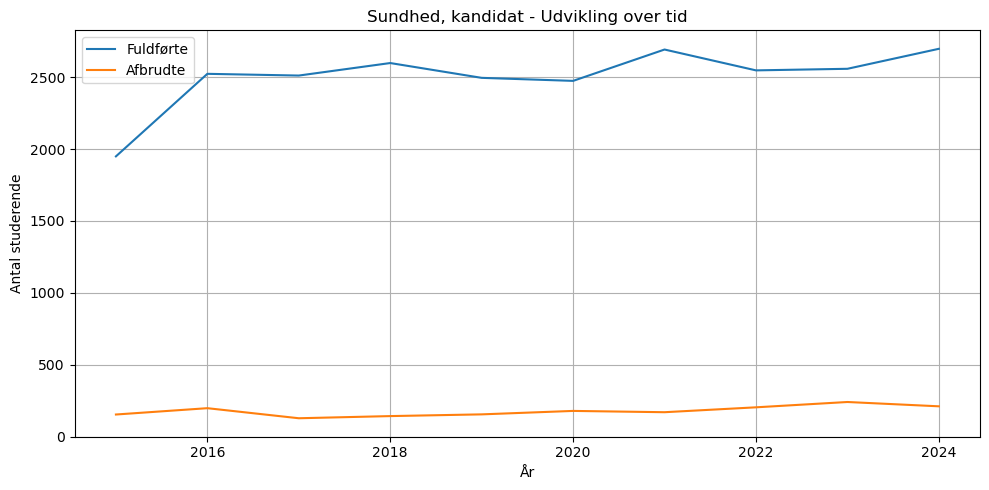

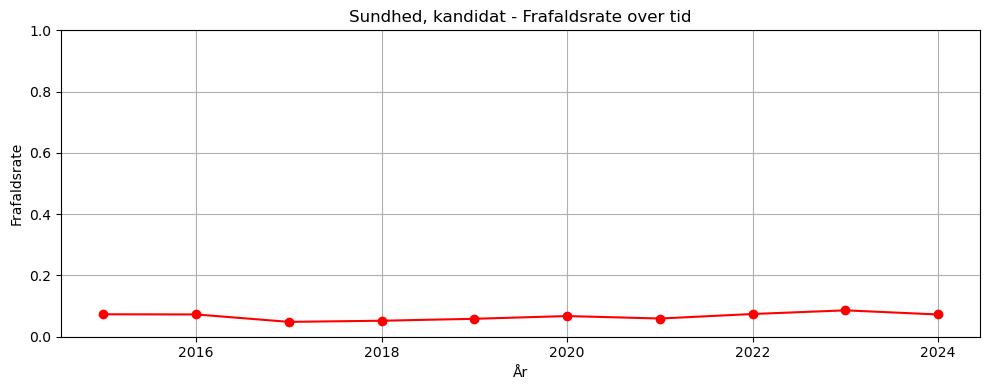

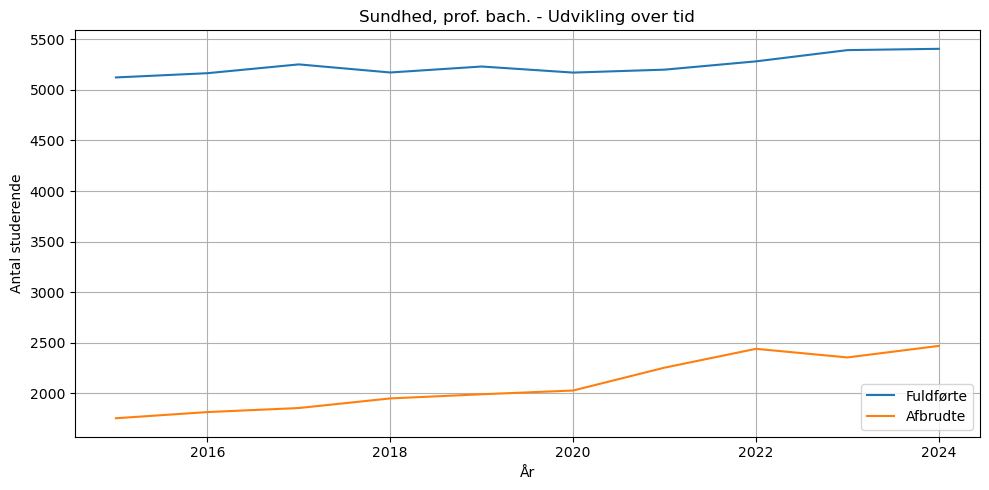

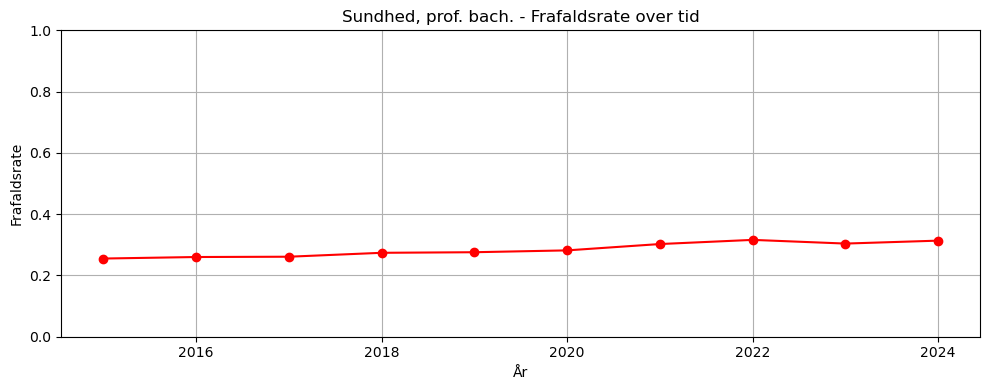

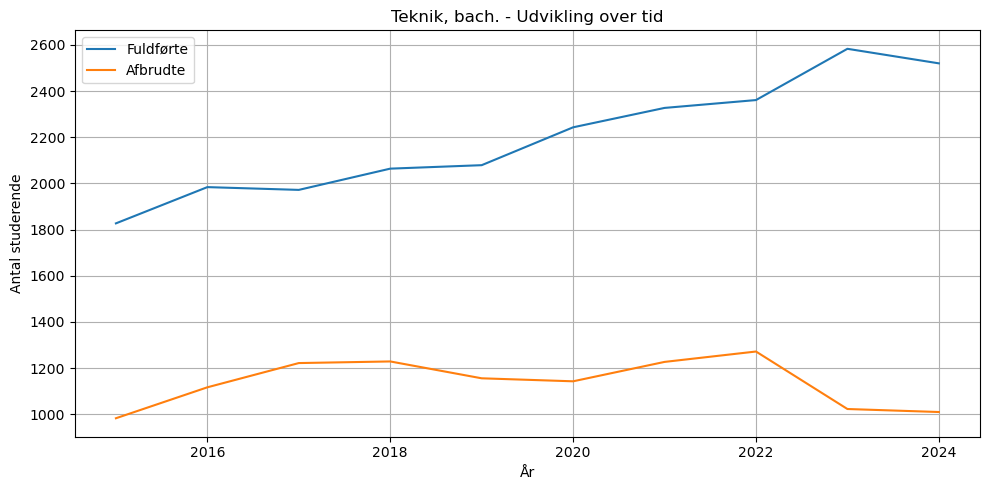

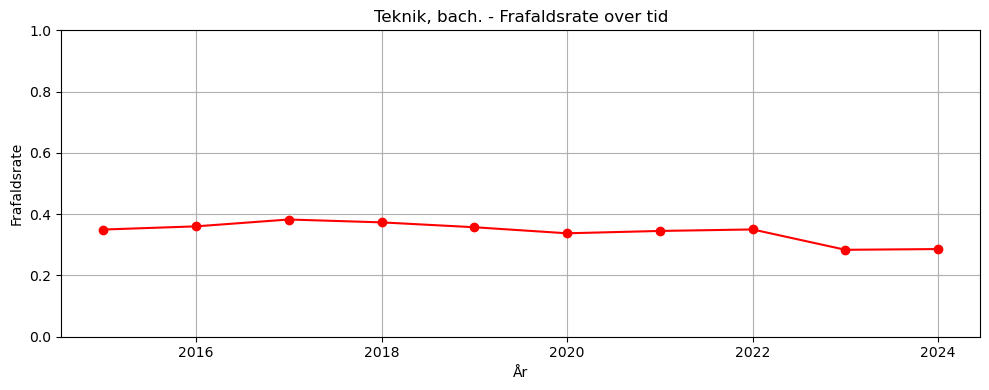

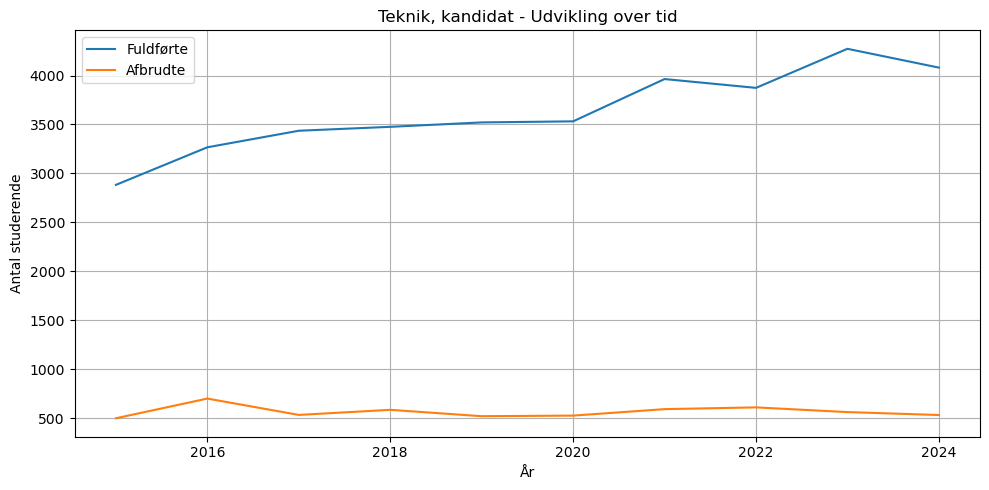

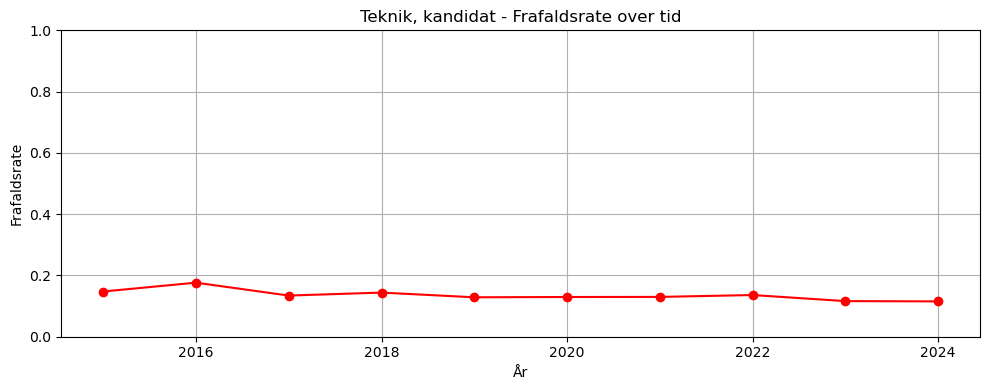

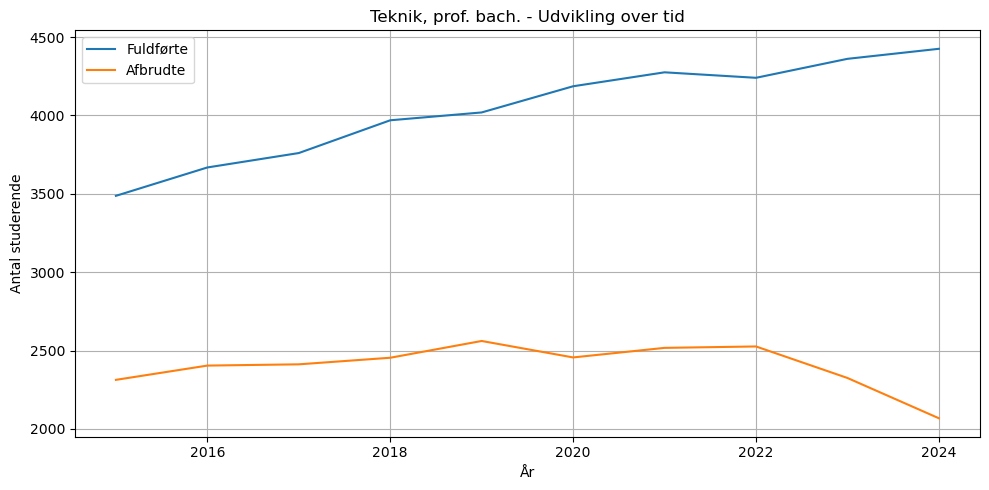

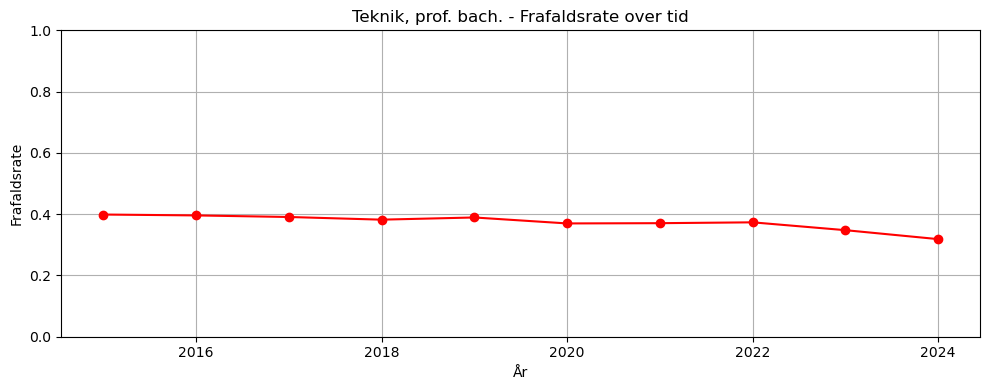

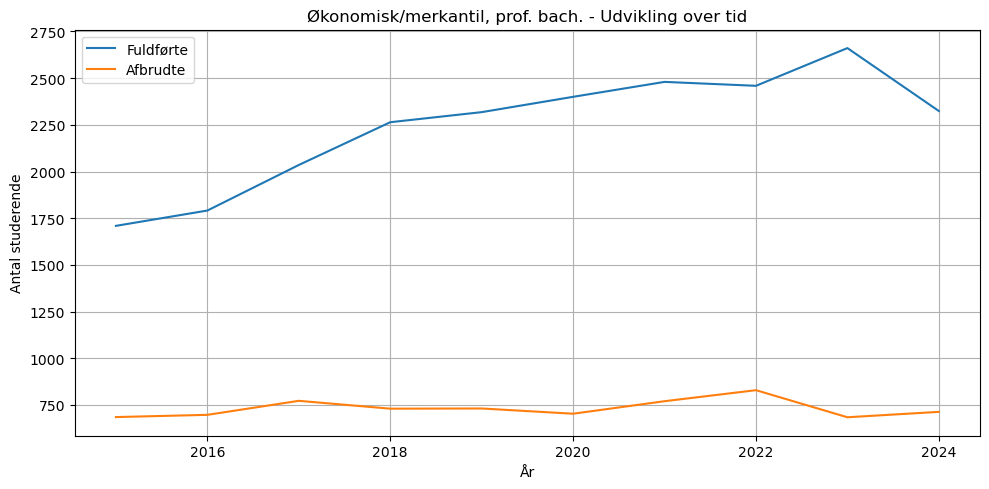

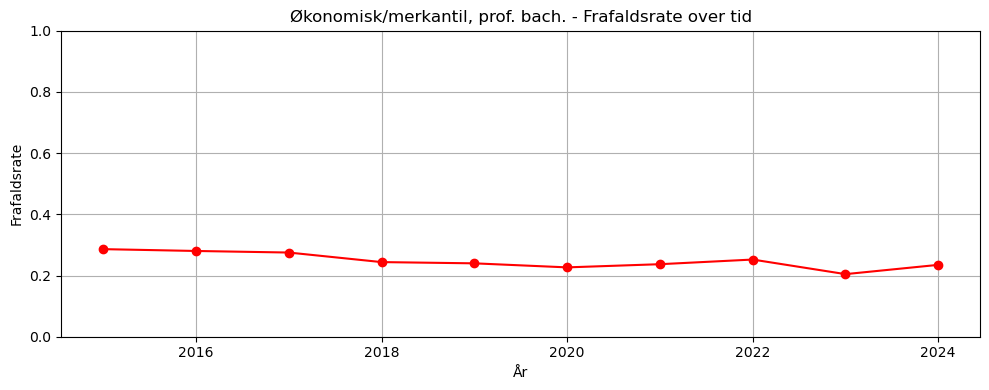

In [214]:
# Visualisering pr. faglinje
years_str = [str(y) for y in years]
for idx, row in merged.iterrows():
    fag = row['FagLinjer']
    fuldførte = row[[f"{y}_fuldfort" for y in years]].values
    afbrudte = row[[f"{y}_afbrudt" for y in years]].values
    total = fuldførte + afbrudte
    frafaldsrate = afbrudte / total

    plt.figure(figsize=(10, 5))
    plt.plot(years, fuldførte, label='Fuldførte')
    plt.plot(years, afbrudte, label='Afbrudte')
    plt.title(f"{fag} - Udvikling over tid")
    plt.xlabel("År")
    plt.ylabel("Antal studerende")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(years, frafaldsrate, color='red', marker='o')
    plt.title(f"{fag} - Frafaldsrate over tid")
    plt.xlabel("År")
    plt.ylabel("Frafaldsrate")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [215]:
# 8. Resultater og fortolkning
summarize_central_tendency(merged)

                           mean        median           std
2015_fuldfort       3401.588235   2516.000000   2174.291812
2016_fuldfort       3985.647059   3061.000000   2810.626797
2017_fuldfort       3760.529412   3026.000000   2444.351067
2018_fuldfort       3718.117647   2919.000000   2295.541246
2019_fuldfort       3728.647059   3026.000000   2303.826869
2020_fuldfort       3729.941176   2815.000000   2318.635953
2021_fuldfort       3862.823529   3503.000000   2305.339786
2022_fuldfort       3738.058824   3172.000000   2332.915544
2023_fuldfort       3788.941176   3318.000000   2263.065881
2024_fuldfort       3744.588235   3263.000000   2285.163371
2015_afbrudt        1454.529412    983.000000   1193.717152
2016_afbrudt        1406.176471   1117.000000   1078.869097
2017_afbrudt        1373.705882   1222.000000   1064.315788
2018_afbrudt        1318.000000   1105.000000    990.951248
2019_afbrudt        1298.352941   1024.000000    981.723099
2020_afbrudt        1249.411765   1084.0

Konklusion
Vi har konstrueret en klassifikationsmodel til at forudsige høj risiko for frafald og en klyngeanalyse til at gruppere uddannelser.
Visualisering og fortolkning af resultaterne muliggør bedre beslutningsstøtte for interessenter.


